In [2]:
# Imports for the entire set of exercises

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, load_breast_cancer, fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Exercise 1: Voting Classifiers

In this exercise, you'll compare hard and soft voting using different base classifiers
on a synthetic dataset.

In [6]:
# Generate a moderately complex dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, 
                         n_redundant=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Base classifiers
log_clf = LogisticRegression(random_state=42)
svc_clf = SVC(probability=True, random_state=42)
knn_clf = KNeighborsClassifier()

# TODO: Create a VotingClassifier with hard voting
# YOUR CODE HERE
voting_hard = VotingClassifier(
    estimators=[('lr', log_clf), ('svc', svc_clf), ('knn', knn_clf)],
    voting='hard'
)

voting_soft = VotingClassifier(
    estimators=[('lr', log_clf), ('svc', svc_clf), ('knn', knn_clf)],
    voting='soft'
)


# Dictionary to store results
results = {}

voting_hard.fit(X_train, y_train)

voting_soft.fit(X_train, y_train)

for clf in (log_clf, svc_clf, knn_clf, voting_hard, voting_soft):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    results[clf.__class__.__name__ + (f" (Voting: {clf.voting})" if isinstance(clf, VotingClassifier) else "")] = acc
    
print(results)



{'LogisticRegression': 0.825, 'SVC': 0.935, 'KNeighborsClassifier': 0.9, 'VotingClassifier (Voting: hard)': 0.915, 'VotingClassifier (Voting: soft)': 0.92}


**Questions:**

1. Which voting method performed better? Why do you think this is the case?
2. How did the ensemble methods compare to individual classifiers?
3. Try adding or removing classifiers - how does this affect performance?

# Exercise 2: Bagging Classifier Exploration

This exercise explores how bagging parameters affect model performance using the breast cancer dataset. We'll use decision trees as our base estimator and explore how different bagging parameters affect the model's performance.

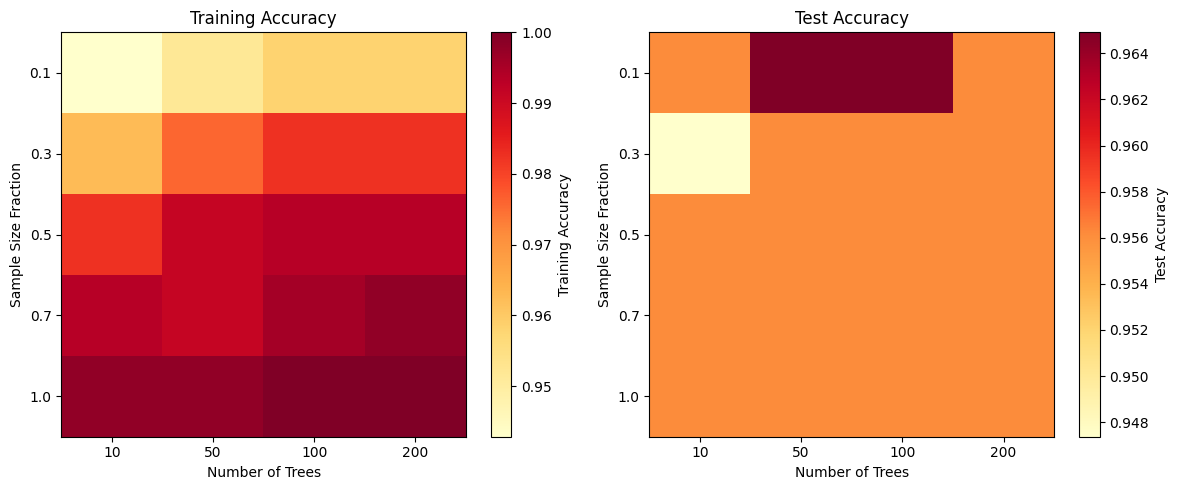

In [15]:

# Load breast cancer dataset
cancer = load_breast_cancer()
X_cancer, y_cancer = cancer.data, cancer.target
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cancer, y_cancer, 
                                                            test_size=0.2, 
                                                            random_state=42)

def evaluate_bagging(n_estimators, max_samples, max_depth=None):
    """
    Creates and evaluates a bagging classifier using decision trees
    
    Parameters:
    -----------
    n_estimators : int
        The number of decision trees in the ensemble
    max_samples : float
        The fraction of samples to draw for training each decision tree
    max_depth : int or None
        The maximum depth of each decision tree
        
    Returns:
    --------
    tuple : (train_score, test_score)
    """
    # Create base decision tree
    tree = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    
    tree = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    
    # Create a BaggingClassifier using the decision tree
    bagging_clf = BaggingClassifier(estimator=tree, n_estimators=n_estimators, 
                                    max_samples=max_samples, n_jobs=-1, random_state=42)
    
    # Fit the model and compute training and test scores
    bagging_clf.fit(X_train_c, y_train_c)
    train_score = bagging_clf.score(X_train_c, y_train_c)
    test_score = bagging_clf.score(X_test_c, y_test_c)
    
    return train_score, test_score
    

# Test different combinations
sample_sizes = [0.1, 0.3, 0.5, 0.7, 1.0]
n_estimators_list = [10, 50, 100, 200]

# Create arrays to store results
train_scores = np.zeros((len(sample_sizes), len(n_estimators_list)))
test_scores = np.zeros((len(sample_sizes), len(n_estimators_list)))


for i, sample_size in enumerate(sample_sizes):
    for j, n_estimators in enumerate(n_estimators_list):
        train_score, test_score = evaluate_bagging(n_estimators, sample_size)
        train_scores[i, j] = train_score
        test_scores[i, j] = test_score

# Visualize results with a heatmap
plt.figure(figsize=(12, 5))

# Training scores heatmap
plt.subplot(121)
plt.imshow(train_scores, cmap='YlOrRd', aspect='auto')
plt.colorbar(label='Training Accuracy')
plt.xticks(range(len(n_estimators_list)), n_estimators_list)
plt.yticks(range(len(sample_sizes)), sample_sizes)
plt.xlabel('Number of Trees')
plt.ylabel('Sample Size Fraction')
plt.title('Training Accuracy')

# Test scores heatmap
plt.subplot(122)
plt.imshow(test_scores, cmap='YlOrRd', aspect='auto')
plt.colorbar(label='Test Accuracy')
plt.xticks(range(len(n_estimators_list)), n_estimators_list)
plt.yticks(range(len(sample_sizes)), sample_sizes)
plt.xlabel('Number of Trees')
plt.ylabel('Sample Size Fraction')
plt.title('Test Accuracy')

plt.tight_layout()
plt.show()

# Bonus investigation: Effect of tree depth
# TODO: Create a similar analysis varying max_depth instead of max_samples
# Try max_depth values of [3, 5, 7, None]
# YOUR CODE HERE

**Questions:**

1. How does the number of trees affect model performance? Is there a point of diminishing returns?
2. What effect does sample size have on overfitting/underfitting? Look at the difference
   between training and test scores.
3. Why might using a very small sample size (0.1) be problematic? What about using 1.0?
4. How does the performance of the bagging classifier compare to a single decision tree?
5. For the bonus investigation: how does tree depth affect the benefits of bagging?

**Additional Challenge:**

1. Add oob_score=True to the BaggingClassifier and compare the OOB score with the test score.
   How well does the OOB score estimate generalization performance?
2. Try using bootstrap=False and compare the results with the default bootstrap=True.
   What differences do you observe and why?

# Exercise 3: Random Forest Parameter Tuning

This exercise explores Random Forest hyperparameters using the California housing dataset.  Note, in this problem, you'll want to use a random forest regressor, rather than a classifier.

In [9]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


housing = fetch_california_housing()
X_house, y_house = housing.data, housing.target
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_house, y_house, 
                                                            test_size=0.2, 
                                                            random_state=42)

def evaluate_rf_params(n_estimators, max_depth, max_features):
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42, max_depth=max_depth, max_features=max_features)
    
    rf.fit(X_train_h, y_train_h)
    
    y_train_pred = rf.predict(X_train_h)
    y_test_pred = rf.predict(X_test_h)
    
    train_rmse = np.sqrt(mean_squared_error(y_train_h, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test_h, y_test_pred))
    
    return train_mse, test_mse
    

results = []

n_estimators = [10, 50, 100]
max_depths = [5, 10, 15, None]
max_features = ['sqrt', 'log2', None]

# Loop through parameter combinations

# Loop through parameter combinations
for n_est in n_estimators:
    for depth in max_depths:
        for feature in max_features:
            train_mse, test_mse = evaluate_rf_params(n_est, depth, feature)
            results.append((n_est, depth, feature, train_mse, test_mse))

# Visualize the results
results_df = pd.DataFrame(results)

In [11]:
results_df = pd.DataFrame(results, columns=['n_estimators', 'max_depth', 'max_features', 'train_rmse', 'test_rmse'])

results_df

,n_estimators,max_depth,max_features,train_rmse,test_rmse
0,10,5.0,sqrt,0.035328,0.255368
1,10,5.0,log2,0.035328,0.255368
2,10,5.0,None,0.035328,0.255368
3,10,10.0,sqrt,0.035328,0.255368
4,10,10.0,log2,0.035328,0.255368
5,10,10.0,None,0.035328,0.255368
6,10,15.0,sqrt,0.035328,0.255368
7,10,15.0,log2,0.035328,0.255368
8,10,15.0,None,0.035328,0.255368
9,10,NaN,sqrt,0.035328,0.255368


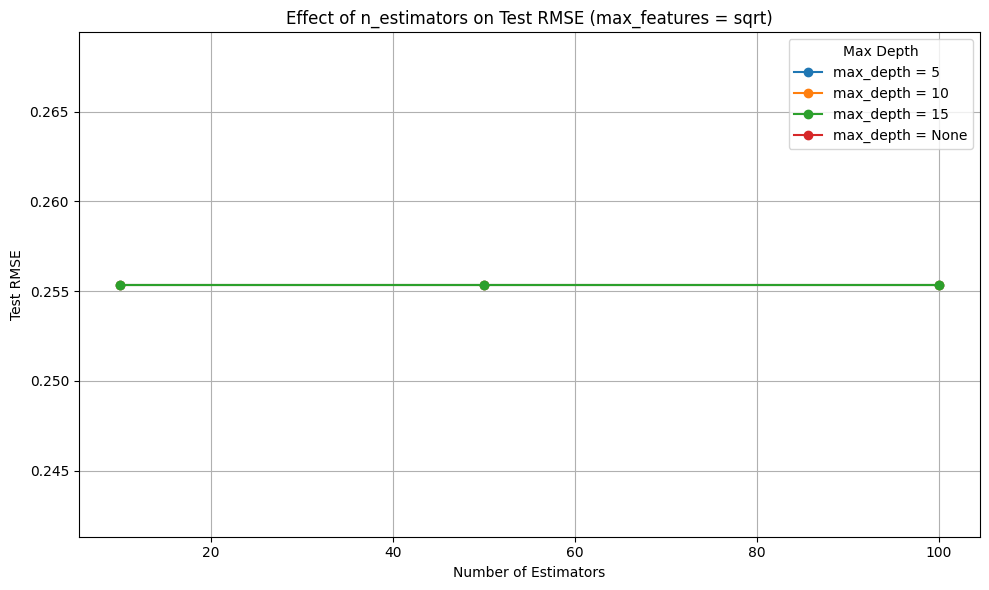

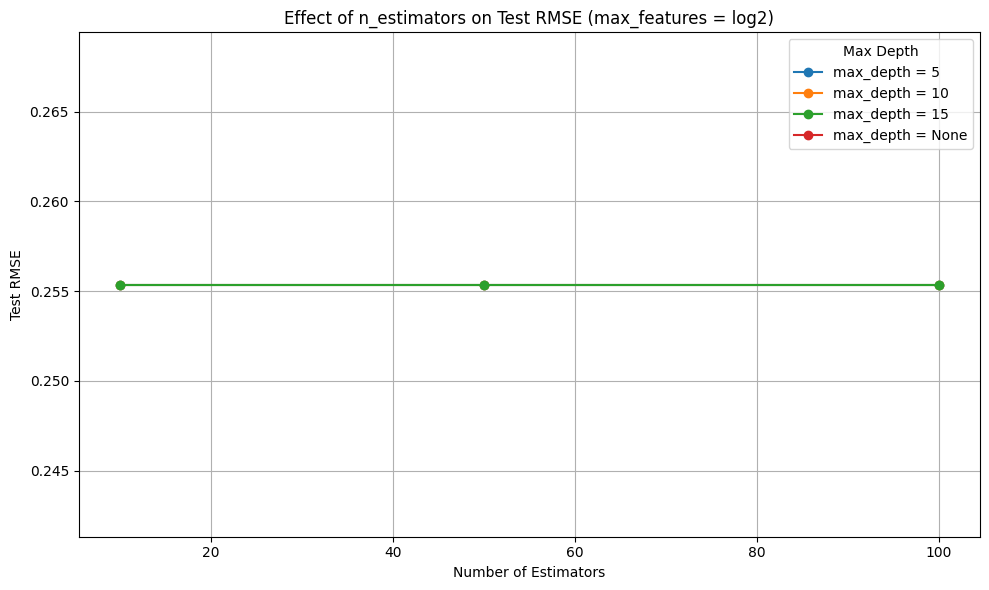

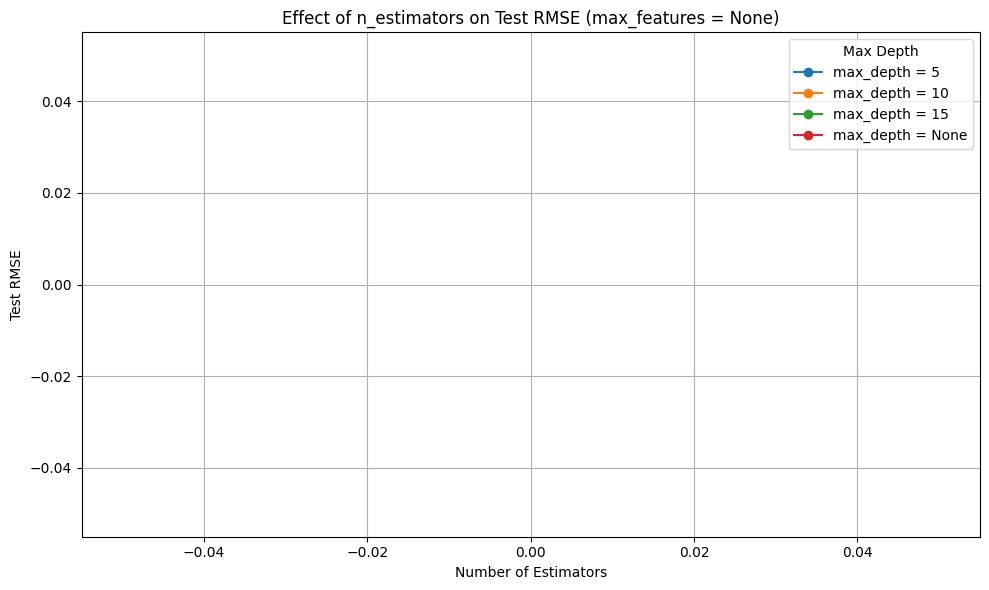

In [14]:
unique_features = results_df['max_features'].unique()

for feature in unique_features:
    # Filter the DataFrame for each 'max_features' value
    feature_df = results_df[results_df['max_features'] == feature]
    
    plt.figure(figsize=(10, 6))

    # Plot test_rmse vs. n_estimators with different lines for each max_depth
    for depth in max_depths:
        depth_df = feature_df[feature_df['max_depth'] == depth]
        plt.plot(depth_df['n_estimators'], depth_df['test_rmse'], marker='o', label=f'max_depth = {depth}')
    
    # Set plot title and labels
    plt.title(f'Effect of n_estimators on Test RMSE (max_features = {feature})')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Test RMSE')
    plt.legend(title='Max Depth')
    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()

**Questions:**

1. How does max_depth affect the bias-variance tradeoff?
2. What's the impact of different max_features settings?
3. At what point do additional trees stop improving performance?

## Exercise 4: Feature Importance Analysis

This exercise explores feature importance in Random Forests using both the breast cancer 
and housing datasets.

In [ ]:
def plot_feature_importance(rf_model, feature_names, title):
    importances = rf_model.feature_importances_
    sorted_idx = np.argsort(importances)

    
    plt.figure(figsize=(10,7))
    plt.barh(range(len(feature_names)), importances[sorted_idx], align='center')
    plt.yticks(range(len(feature_names)), feature_names[sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importancec {title}')
    plt.show()

rf_cancer = RandomForestClassifier(n_estimators=100)
rf_cancer.fit(X_train_c, y_train_c)

rf_house = RandomForestClassifier(n_estimators=100)
rf_house.fit(X_train_h, y_train_h)

plot_feature_importance(rf_model=rf_cancer, cancer.feature_names, "Cancer")

SyntaxError: positional argument follows keyword argument (1132968840.py, line 18)

**Questions:**

1. Which features are most important for each dataset?
2. How stable are the importance rankings across multiple runs?
3. How could you use this information for feature selection?

# Exercise 5: Out-of-Bag Evaluation

This exercise compares Out-of-Bag (OOB) evaluation with cross-validation for error 
estimation in Random Forests. You'll see how these different evaluation methods compare
and when you might want to use each one.

We'll use both the breast cancer dataset (classification) and a simpler synthetic
dataset to understand how these evaluation methods work.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import time

# Create a synthetic dataset for initial exploration
X_simple, y_simple = make_classification(n_samples=1000, n_features=10, 
                                       n_informative=5, random_state=42)

# Load the breast cancer dataset
cancer = load_breast_cancer()
X_cancer, y_cancer = cancer.data, cancer.target

def get_oob_scores(X, y, n_estimators_range, random_state=42):
    """
    Calculate OOB scores for different numbers of estimators.
    
    Parameters:
    -----------
    X : array-like
        Training data
    y : array-like
        Target values
    n_estimators_range : array-like
        Range of n_estimators values to test
    random_state : int
        Random state for reproducibility
        
    Returns:
    --------
    tuple : (oob_scores, computation_times)
    """
    oob_scores = []
    computation_times = []
    
    for n_estimators in n_estimators_range:
        # TODO: Create a RandomForestClassifier with oob_score=True
        # Use n_jobs=-1 to utilize all CPU cores
        rf = None  # YOUR CODE HERE
        
        # Time the fitting process
        start_time = time.time()
        # TODO: Fit the random forest
        # YOUR CODE HERE
        computation_time = time.time() - start_time
        
        # TODO: Get the oob score and append it to oob_scores
        # YOUR CODE HERE
        
        computation_times.append(computation_time)
    
    return np.array(oob_scores), np.array(computation_times)

def get_cv_scores(X, y, n_estimators_range, cv=5, random_state=42):
    """
    Calculate cross-validation scores for different numbers of estimators.
    
    Parameters:
    -----------
    X : array-like
        Training data
    y : array-like
        Target values
    n_estimators_range : array-like
        Range of n_estimators values to test
    cv : int
        Number of cross-validation folds
    random_state : int
        Random state for reproducibility
        
    Returns:
    --------
    tuple : (cv_scores_mean, cv_scores_std, computation_times)
    """
    cv_scores_mean = []
    cv_scores_std = []
    computation_times = []
    
    for n_estimators in n_estimators_range:
        # TODO: Create a RandomForestClassifier (without OOB)
        rf = None  # YOUR CODE HERE
        
        # Time the cross-validation process
        start_time = time.time()
        # TODO: Perform cross-validation and get scores
        # Hint: use cross_val_score from sklearn
        scores = None  # YOUR CODE HERE
        computation_time = time.time() - start_time
        
        # TODO: Calculate and store mean and std of CV scores
        # YOUR CODE HERE
        
        computation_times.append(computation_time)
    
    return (np.array(cv_scores_mean), np.array(cv_scores_std), 
            np.array(computation_times))

# Test range of estimators
n_estimators_range = [10, 20, 50, 100, 200]

def plot_comparison(X, y, title):
    """
    Plot OOB scores vs CV scores and computation times.
    """
    # Get scores and computation times
    oob_scores, oob_times = get_oob_scores(X, y, n_estimators_range)
    cv_scores_mean, cv_scores_std, cv_times = get_cv_scores(X, y, n_estimators_range)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot scores
    ax1.plot(n_estimators_range, oob_scores, 'b-', label='OOB Score')
    ax1.plot(n_estimators_range, cv_scores_mean, 'r-', label='CV Score')
    ax1.fill_between(n_estimators_range, 
                    cv_scores_mean - cv_scores_std,
                    cv_scores_mean + cv_scores_std, 
                    alpha=0.2, color='r')
    ax1.set_xlabel('Number of Estimators')
    ax1.set_ylabel('Score')
    ax1.set_title(f'OOB vs CV Scores - {title}')
    ax1.legend()
    ax1.grid(True)
    
    # Plot computation times
    ax2.plot(n_estimators_range, oob_times, 'b-', label='OOB Time')
    ax2.plot(n_estimators_range, cv_times, 'r-', label='CV Time')
    ax2.set_xlabel('Number of Estimators')
    ax2.set_ylabel('Computation Time (seconds)')
    ax2.set_title(f'Computation Times - {title}')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# TODO: Run comparisons on both datasets
# Compare OOB and CV on simple synthetic dataset
plot_comparison(X_simple, y_simple, "Synthetic Dataset")

# Compare OOB and CV on breast cancer dataset
plot_comparison(X_cancer, y_cancer, "Breast Cancer Dataset")

**Questions:**

1. How do the OOB and CV scores compare? Are they similar or different?
   - Look at both the mean values and the trends as n_estimators increases
   - Which method gives more optimistic/pessimistic estimates?

2. Compare the computation times:
   - Which method is faster? By how much?
   - How does the difference in computation time scale with n_estimators?
   - Why might one method be faster than the other?

3. Looking at the synthetic vs real dataset:
   - Are the results similar or different?
   - Which dataset shows more variance in the scores?
   - Can you explain any differences you observe?

4. Practical considerations:
   - When might you prefer to use OOB evaluation?
   - When might cross-validation be a better choice?
   - What are the advantages and disadvantages of each method?

**Additional Challenges:**

1. Modify the code to test different cross-validation fold numbers (cv parameter).
   How does this affect both the scores and computation time?

2. Add error bars to the OOB scores by running multiple times with different
   random states. How stable are the OOB scores compared to CV scores?

3. Try different parameters for the RandomForestClassifier (e.g., max_depth,
   max_features). How do these affect the comparison between OOB and CV scores?